# Decision Tree
---
## Overview
* **Task:** Using dataset of titanic: machine learning from disaster (you can check https://www.kaggle.com/c/titanic/data for details) to train a decision tree model so that it predicts whether a passenger can survive given corresponding imformation in type of category, text, and number.
* **Input:** train_file with labels: ../input/titanic/train.csv & test_file without labels: ../input/titanic/test.csv
* **Label:**

| Index | Variable   | Definition                                                   | Type |
| ----- | ---------- | ------------------------------------------------------------ | ---- |
| 0     | 'Pclass'   | Passenger's class (1st, 2nd, or 3rd)                         | cat  |
| 1     | 'Name'     | Passenger's name                                             | text |
| 2     | 'Sex'      | Passenger's sex                                              | cat  |
| 3     | 'Age'      | Passenger's age                                              | num  |
| 4     | 'SibSp'    | Number of siblings/spouses aboard the Titanic                | cat  |
| 5     | 'Parch'    | Number of parents/children aboard the Titanic                | cat  |
| 6     | 'Ticket'   | Ticket number                                                | text |
| 7     | 'Fare'     | Fare paid for ticket                                         | num  |
| 8     | 'Cabin'    | Cabin number                                                 | set  |
| 9     | 'Embarked' | Where the passenger got on the ship (C - Cherbourg, S - Southampton, Q = Queenstown) | cat  |

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

### 1. Data Preparation

In [2]:
CAT_FEAT = [0, 2, 4, 5, 9]
NUM_FEAT = [3, 7]

In [4]:
# parse a string into fields, skip quotations
def parse_feat(line):
    quota = False
    j = 0
    feats = []
    for i in range(len(line)):
        if line[i] == '\"':
            quota = not quota
        if line[i] == ',' and not quota:
            feat = line[j:i]
            feats.append(feat)
            j = i+1
    return feats + [line[j:]]


# load a csv file, use parse_feat() to convert format
def load_file(file_name):
    data = []
    with open(file_name, 'r') as fin:
        print('field_names:', fin.readline().strip().split(','))
        for line in fin:
            line = line.strip()
            data.append(parse_feat(line))
    return np.array(data)

train_data = load_file('../../data/train.csv')
test_data = load_file('../../data/test.csv')

train_id, train_label, train_feat = train_data[:, 0], train_data[:, 1], train_data[:, 2:]
test_id, test_feat = test_data[:, 0], test_data[:, 1:]

print('train_feat:\n', train_feat[0])
print('test_feat:\n', test_feat[0])

train_feat[:, [1, 6, 8]] = None
test_feat[:, [1, 6, 8]] = None

print('train_feat:\n', train_feat[0])
print('test_feat:\n', test_feat[0])

field_names: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
field_names: ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
train_feat:
 ['3' '"Braund, Mr. Owen Harris"' 'male' '22' '1' '0' 'A/5 21171' '7.25' ''
 'S']
test_feat:
 ['3' '"Kelly, Mr. James"' 'male' '34.5' '0' '0' '330911' '7.8292' '' 'Q']
train_feat:
 ['3' 'None' 'male' '22' '1' '0' 'None' '7.25' 'None' 'S']
test_feat:
 ['3' 'None' 'male' '34.5' '0' '0' 'None' '7.8292' 'None' 'Q']


CART classification tree can deal with continuous numerical features by discretization.

Suppose there are $m$ samples, where the continuous feature $A$ has $m$ different values, sorted by $a_1, a_2, \dots, a_m$.

1. Taking the average of two adjacent samples as the dividing point, and obtaining $m-1$ dividing points

2. The data is divided into two categories at each division point, and the Gini coefficient is calculated.

3. Select the point with the smallest Gini coefficient as the dividing point of the continuous feature

In this example, we would like to implement basic ID3 classification tree, so we discretize the continuous features in a similar way during data preprocessing as follows:

[ 0.17   8.153 16.136 24.119 32.102 40.085 48.068 56.051 64.034 72.017]


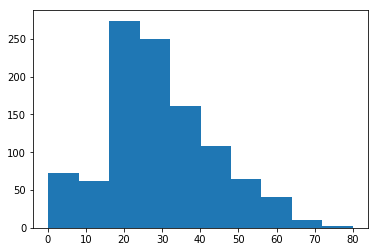

[  0.       51.23292 102.46584 153.69876 204.93168 256.1646  307.39752
 358.63044 409.86336 461.09628]


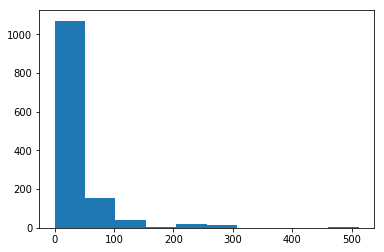

In [5]:
# return a separator to categorize a numerical field
def num2cat(num_feat, n_class=10):
    def to_float(x):
        if len(x):
            return float(x)
        else:
            return -1

    num_feat = np.array([to_float(x) for x in num_feat])
    min_val, max_val = num_feat[num_feat > -1].min(), num_feat.max()
    sep = np.linspace(min_val, max_val, n_class, endpoint=False)
    print(sep)
    plt.hist(num_feat[num_feat > -1], bins=n_class) 
    plt.show()

    def indicator(x):
        x = to_float(x)
        if x == -1:
            return 0
        for i in range(len(sep)):
            if x < sep[i]:
                return i    
        return n_class

    return indicator


for nf in NUM_FEAT:
    ind = num2cat(list(train_feat[:, nf]) + list(test_feat[:, nf]))
    for _ in range(len(train_feat[:, nf])):
        train_feat[_, nf] = str(ind(train_feat[_, nf]))
    for _ in range(len(test_feat[:, nf])):
        test_feat[_, nf] = str(ind(test_feat[_, nf]))

In [6]:
train_feat = np.delete(train_feat, [1, 6, 8], axis=1)
test_feat = np.delete(test_feat, [1, 6, 8], axis=1)

print('train_feat:\n', train_feat)
print('test_feat:\n', test_feat)

train_feat:
 [['3' 'male' '3' ... '0' '1' 'S']
 ['1' 'female' '5' ... '0' '2' 'C']
 ['3' 'female' '4' ... '0' '1' 'S']
 ...
 ['3' 'female' '0' ... '2' '1' 'S']
 ['1' 'male' '4' ... '0' '1' 'C']
 ['3' 'male' '4' ... '0' '1' 'Q']]
test_feat:
 [['3' 'male' '5' ... '0' '1' 'Q']
 ['3' 'female' '6' ... '0' '1' 'S']
 ['2' 'male' '8' ... '0' '1' 'Q']
 ...
 ['3' 'male' '5' ... '0' '1' 'S']
 ['3' 'male' '0' ... '0' '1' 'S']
 ['3' 'male' '0' ... '1' '1' 'C']]


In [7]:
class Dataset:
    # build feature map for one-hot encoding
    @staticmethod
    def build_feat_map(cat_feats):
        feat_map = {}
        for i in range(cat_feats.shape[1]):
            for x in cat_feats[:, i]:
                feat_name = str(i) + ':' + x
                if feat_name not in feat_map:
                    feat_map[feat_name] = len(feat_map)

        return feat_map
    
    # one-hot encoding
    def feat2id(self, cat_feats):
        feat_ids = []
        for i in range(cat_feats.shape[1]):
            feat_ids.append([])
            for x in cat_feats[:, i]:
                feat_name = str(i) + ':' + x
                feat_ids[-1].append(self.feat_map[feat_name])
        return np.int32(feat_ids).transpose()
    
    # split validation set
    def split_train_valid(self):
        np.random.seed(123)
        rnd = np.random.random(len(self.train_label))
        self.train_ind = np.where(rnd < 0.8)[0]
        self.valid_ind = np.where(rnd >= 0.8)[0]

        def to_csr(data, dim=len(self.feat_map)):
            row = np.zeros_like(data) + np.expand_dims(np.arange(len(data)), 1)
            val = np.ones_like(data)
            return csr_matrix((val.flatten(), (row.flatten(), data.flatten())), shape=(len(data), dim))    
            
        self.train_data = (self.train_label[self.train_ind], to_csr(self.train_feat[self.train_ind]))
        self.valid_data = (self.train_label[self.valid_ind], to_csr(self.train_feat[self.valid_ind]))
        self.test_data = (np.zeros(len(self.test_feat), dtype=np.int32), to_csr(self.test_feat))
    
    def __init__(self):
        self.feat_map = self.build_feat_map(np.vstack([train_feat, test_feat]))

        self.train_id, self.test_id = train_id, test_id
        self.train_label = np.int32(train_label)
        self.train_feat, self.test_feat = self.feat2id(train_feat), self.feat2id(test_feat)

        print('train_feat:\n', self.train_feat)
        print('test_feat:\n', self.test_feat)

        self.split_train_valid()
        
Data = Dataset()

train_feat:
 [[ 0  3  5 ... 23 31 39]
 [ 1  4  6 ... 23 32 40]
 [ 0  4  7 ... 23 31 39]
 ...
 [ 0  4  8 ... 25 31 39]
 [ 1  3  7 ... 23 31 40]
 [ 0  3  7 ... 23 31 41]]
test_feat:
 [[ 0  3  6 ... 23 31 41]
 [ 0  4 14 ... 23 31 39]
 [ 2  3 12 ... 23 31 41]
 ...
 [ 0  3  6 ... 23 31 39]
 [ 0  3  8 ... 23 31 39]
 [ 0  3  8 ... 24 31 40]]


In [8]:
train_label, train_feat = Data.train_data[0], Data.train_data[1].toarray()
valid_label, valid_feat = Data.valid_data[0], Data.valid_data[1].toarray()

print('train_feat:\n', train_feat)
print('valid_feat:\n', valid_feat)

train_feat:
 [[1 0 0 ... 0 0 0]
 [0 1 0 ... 1 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 1 0 ... 1 0 0]
 [1 0 0 ... 0 1 0]]
valid_feat:
 [[0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


### 2. Implemention of Decision Tree Class

$$H(X)=-\sum_{i=1}^{n}p_i\log{p_i}$$

$$H(X|Y)=\sum_{i=1}^{n}p(Y=y_i)H(X|Y=y_i)$$

$$g(X,Y)=H(X)-H(X|Y)$$

In [9]:
NID = {}


class Node:
    def __init__(self, feat_id=-1):
        self.feat_id = feat_id
        self.nid = len(NID)
        NID[self.nid] = self
        self.t_child = None
        self.f_child = None
        self._class = -1
        

class DecisionTree:
    def __init__(self, n_feat, max_depth=6, verbose=True):
        self.n_feat = n_feat
        self.max_depth = max_depth
        self.verbose = verbose
        self.root_node = Node()

    @staticmethod
    def entropy(labels):
        p = np.sum(labels) / len(labels)
        if p == 0 or p == 1:
            return 0
        return - p * np.log(p) - (1-p) * np.log(1-p)

    def fit(self, labels, data, cur_node=None, cur_depth=1):
        if cur_node is None:
            cur_node = self.root_node

        if self.verbose:
            print(cur_node.nid)
        
        if labels.sum() == len(labels):
            cur_node._class = 1
            cur_node.t_child = None
            cur_node.f_child = None
            return
        elif labels.sum() == 0:
            cur_node._class = 0
            cur_node.t_child = None
            cur_node.f_child = None
            return
        elif cur_depth == self.max_depth:
            cur_node._class = labels.sum() / len(labels) >= 0.5
            cur_node.t_child = None
            cur_node.f_child = None
            return
        
        base_ent = self.entropy(labels)
        info_gain = 0
        best_split = None
        best_t_ind = None
        best_f_ind = None
        
        csc_data = data.tocsc()
        for f in range(self.n_feat):
            feat = csc_data[:, f].toarray().flatten()
            t_ind = feat == 1
            f_ind = feat == 0
            f_ent = base_ent
            if t_ind.sum():
                f_ent -= t_ind.sum() / len(feat) * self.entropy(labels[t_ind])
            if f_ind.sum():
                f_ent -= f_ind.sum() / len(feat) * self.entropy(labels[f_ind])
            if info_gain < f_ent:
                info_gain = f_ent
                best_split = f
                best_t_ind = t_ind
                best_f_ind = f_ind
                
        if info_gain == 0:
            cur_node._class = labels.sum() / len(labels) >= 0.5
            cur_node.t_child = None
            cur_node.f_child = None
            return
                
        cur_node.feat_id = best_split
        cur_node.t_child = Node()
        cur_node.f_child = Node()
        
        self.fit(labels[best_t_ind], data[best_t_ind], cur_node.t_child, cur_depth+1)
        self.fit(labels[best_f_ind], data[best_f_ind], cur_node.f_child, cur_depth+1)

    def predict(self, data):
        assert data.ndim == 1
        cur_node = self.root_node
        feat_set = set(data)

        while True:
            if cur_node.t_child is None or cur_node.f_child is None:
                return cur_node._class
            if cur_node.feat_id in feat_set:
                cur_node = cur_node.t_child
            else:
                cur_node = cur_node.f_child

    def batch_predict(self, data):
        preds = []
        for i in range(data.shape[0]):
            preds.append(self.predict(data[i].tocoo().col))
        return np.array(preds)

    def acc(self, labels, data):
        preds = self.batch_predict(data)
        acc = np.int32(labels == preds).sum() / len(labels)
        return acc

DT = DecisionTree(len(Data.feat_map), max_depth=5, verbose=False)   #超参调节max_depth
DT.fit(*Data.train_data)

print(DT.acc(*Data.train_data))
print(DT.acc(*Data.valid_data))

0.8231966053748232
0.7717391304347826


### 3. Implemention with Sklearn Package

In [10]:
from sklearn import tree

train_label, train_feat = Data.train_data[0], Data.train_data[1].toarray()
valid_label, valid_feat = Data.valid_data[0], Data.valid_data[1].toarray()

print('train_feat:\n', train_feat)
print('valid_feat:\n', valid_feat)

train_feat:
 [[1 0 0 ... 0 0 0]
 [0 1 0 ... 1 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 1 0 ... 1 0 0]
 [1 0 0 ... 0 1 0]]
valid_feat:
 [[0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


In [11]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=10)
clf.fit(train_feat, train_label)

train_preds = clf.predict(train_feat)
valid_preds = clf.predict(valid_feat)
print('train acc:', np.sum(train_preds == train_label) / len(train_label))
print('valid acc:', np.sum(valid_preds == valid_label) / len(valid_label))

train acc: 0.8769448373408769
valid acc: 0.8043478260869565


### 4. Visualization of Decision Tree

In [13]:
from sklearn.externals.six import StringIO
import pydotplus

# graphviz
!pip install pydotplus
dot_data = StringIO()
tree.export_graphviz(clf,
                    out_file=dot_data,
                    feature_names=sorted(sorted(Data.feat_map.keys())),
                    class_names=['non-survival', 'survival'],
                    filled=True, rounded=True,
                    impurity=False)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_pdf('viz.pdf')

ModuleNotFoundError: No module named 'pydotplus'